<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-ventilator-pressure-prediction/blob/main/vp_colab/ventilator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

import os
import os.path

#Load data

In [2]:
# Make a file for models
file_path = f'models/{datetime.datetime.now().strftime("%Y %H:%M")}'
if os.path.exists(file_path) == False:
  os.makedirs(file_path)


In [16]:
!git clone https://github.com/panekvit/su_data.git

Cloning into 'su_data'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [17]:


data = pd.read_csv('/content/su_data/data.csv')
target_pres = data.pressure.copy()

In [19]:
data.drop('id',axis=1,inplace=True)

# Feature engineering

In [20]:
data['step'] = list(range(80))*data['breath_id'].nunique()
data['u_in_min'] = data['breath_id'].map(data.groupby('breath_id')['u_in'].min())

data['u_in_diff'] = data['u_in'].diff()
data.loc[data['step']<1, 'u_in_diff'] = 0

data['time_diff'] = data['time_step'].diff()
data.loc[data['step']<1, 'time_diff'] = 0

data['inhaled_air'] = data['time_diff']*data['u_in']

data['inhaled_diff_lag'] = data['inhaled_air'].diff().shift(1)
data.loc[data['step']<2, 'inhaled_diff_lag'] = 0



#data['pressure'] = data['pressure'].diff()
#data.loc[data['step']<1, 'pressure'] = 0

#Make a lead
#df['pressure_lead'] = df.pressure.shift(-1)

## Lag functions


In [21]:
def create_lag_all(df, lags):
  res = df.copy()
  for lag in lags:
    df1 = df.copy()
    df1 = df1.shift(lag)
    res = pd.merge(res,df1.rename(columns = lambda x: x+f'_{lag}lag'),left_index=True,right_index=True)
  
  return res

def create_lag_feature(df, lags, features):
  res = df.copy()
  for feature in features:
    for lag in lags:
      df1 = df.copy()
      df1 = df1[feature].shift(lag)
      df1 = pd.DataFrame(df1)
      res = pd.merge(res,df1.rename(columns = lambda x: x+f'_{lag}lag'),left_index=True,right_index=True)    
      res.loc[res['step']<lag, feature+f'_{lag}lag'] = 0
  return res


# RNN, LSTM, GRU

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Functions and Classes

###Preprocess


In [24]:
#OneHot encoding

def onehot_encode_pd(df, col_name):
    dummies = pd.get_dummies(df[col_name], prefix=col_name)
    return pd.concat([df, dummies], axis=1).drop(columns=[col_name])

# Feature label split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

# Split function

def train_val_test_split(df, target_col, test_ratio, random_state):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Scalers

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()


### Models

In [25]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :].to(device)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :].to(device)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [27]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :].to(device)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [28]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### Train and eval

In [29]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=80, n_epochs=50, n_features=1, model_path = 'model'):

      for epoch in range(1, n_epochs + 1):
          batch_losses = []
          for x_batch, y_batch in train_loader:
              x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
              y_batch = y_batch.to(device)
              loss = self.train_step(x_batch, y_batch)
              batch_losses.append(loss)
          training_loss = np.mean(batch_losses)
          self.train_losses.append(training_loss)

          with torch.no_grad():
              batch_val_losses = []
              for x_val, y_val in val_loader:
                  x_val = x_val.view([batch_size, -1, n_features]).to(device)
                  y_val = y_val.to(device)
                  self.model.eval()
                  yhat = self.model(x_val)
                  val_loss = self.loss_fn(y_val, yhat).item()
                  batch_val_losses.append(val_loss)
              validation_loss = np.mean(batch_val_losses)
              self.val_losses.append(validation_loss)

          if (epoch <= 10) | (epoch % 50 == 0):
              print(
                  f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
              )
      torch.save(self.model.state_dict(), model_path)
      val_loss = pd.DataFrame(self.val_losses)
      train_loss = pd.DataFrame(self.train_losses)
      losses = pd.concat([train_loss, val_loss], axis = 1)
      losses.columns = ['train_loss','val_loss']
      losses.to_csv(file_path + '/losses.csv')

    def evaluate(self, test_loader, batch_size=1, n_features=1):
      with torch.no_grad():
          predictions = []
          values = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              predictions.append(yhat.to('cpu').detach().numpy())
              values.append(y_test.to('cpu').detach().numpy())

      return predictions, values

    def plot_losses(self, file_path):
      plt.plot(self.train_losses, label="Training loss")
      plt.plot(self.val_losses, label="Validation loss")
      plt.legend()
      plt.title("Losses")
      fig1 = plt.gcf()
      plt.show()
      fig1.savefig(file_path + '/plot_loss.png', dpi=100)
      plt.close()

### Prediction

In [30]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}



## Model

### Preprocess

In [31]:
# Pick data and do OneHot

df = data.copy()
df = df[0:10000]
df = onehot_encode_pd(df,'R')
df = onehot_encode_pd(df,'C')

# Create lag features

df = create_lag_feature(df, lags = range(40), features = ['u_in', 'inhaled_diff_lag', 'inhaled_air',]).fillna(0)

# Split data to train, val, test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df, 'pressure', 0.2, 42)

# Choose scaler and scale it!

scaler = get_scaler('robust')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

# Choose batch size and make it a model friendly dtype

batch_size = 80

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

### Train model

In [32]:
# Choose parametres

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 80
layer_dim = 3
batch_size = 80
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

In [33]:
# Choose model type: rnn, lstm, gru

model_type = 'lstm'

In [34]:
# Define model, loss function and optimizer 

model = get_model(model_type, model_params).to(device)

loss_fn = nn.L1Loss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)


In [35]:
# Set model path
model_path = file_path + f'/{model}'

[1/10] Training loss: 0.6311	 Validation loss: 0.4122
[2/10] Training loss: 0.4680	 Validation loss: 0.3474
[3/10] Training loss: 0.4223	 Validation loss: 0.3443
[4/10] Training loss: 0.3972	 Validation loss: 0.3379
[5/10] Training loss: 0.3883	 Validation loss: 0.3334
[6/10] Training loss: 0.3797	 Validation loss: 0.3398
[7/10] Training loss: 0.3630	 Validation loss: 0.3410
[8/10] Training loss: 0.3663	 Validation loss: 0.3416
[9/10] Training loss: 0.3666	 Validation loss: 0.3487
[10/10] Training loss: 0.3612	 Validation loss: 0.3542


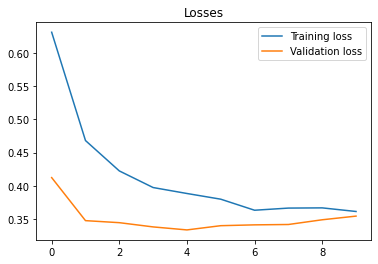

In [36]:
# Train

opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim, model_path = model_path)
opt.plot_losses(file_path = file_path)

### Prediction

Load model if needed


```
the_model = get_model('lstm', model_params).to(device)
the_model = the_model.load_state_dict(torch.load('models/lstm'))
the_model.eval()
opt = Optimization(model=the_model, loss_fn=loss_fn, optimizer=optimizer)

```



In [37]:
# Evaluate

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
df_result = format_predictions(predictions, values, X_test, scaler)

## Results

In [38]:
# Results for all observations

result_metrics_all = calculate_metrics(df_result)
result_metrics_all

{'mae': 3.034091, 'r2': 0.5689531508420651, 'rmse': 5.746360290278827}

In [39]:
# Result only for u_out = 0

dff = pd.DataFrame(df_result)
dff['id'] = dff.index
idx0 = df[df.u_out == 0].index
idx = pd.DataFrame(idx0)
idx.rename(columns = {0:'id'}, inplace = True)
res = pd.merge(dff,idx, on ='id', how = 'inner')

result_metrics_out0 = calculate_metrics(res)
result_metrics_out0

{'mae': 5.534005, 'r2': 0.2953861425090941, 'rmse': 8.200562285706866}

#Save

In [40]:
# Prepare data for .csv

out0 = pd.DataFrame(result_metrics_out0, index = [0])
out0['data'] = 'u_out=0'
all_res = pd.DataFrame(result_metrics_all,index = [1])
all_res['data'] = 'all'
errors = pd.concat([out0,all_res])

params_to_save = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout,
                'batch_size' : batch_size,
                'n_epochs' : n_epochs,
                'learning_rate' : learning_rate,
                'weight_decay' : weight_decay,
                'model_type' : model_type}

params = pd.DataFrame(params_to_save, index = [0])

In [41]:
# Save results, errors, parametres

df_result.to_csv(file_path + '/df_result.csv')
errors.to_csv(file_path + '/errors.csv')
params.to_csv(file_path + '/params.csv')

In [42]:
# Rename file
mae = round(errors.mae[0],3)
os.rename(file_path,"models/" + f'{model_type}_mae{format(mae,".3f")}')